In [1]:
from datasets import load_dataset, load_from_disk

from utils import *

In [2]:
rng = PRNG(0)

In [3]:
run = 'easy-deluge-92_wubsk6w2'         # Tweedie
# run = 'carbonite-jawa-89_spp46l9r'      # Σ_t
# run = 'feasible-waterfall-85_50itfwu7'  # (I + Σ_t^{-1})^{-1}

## Prior

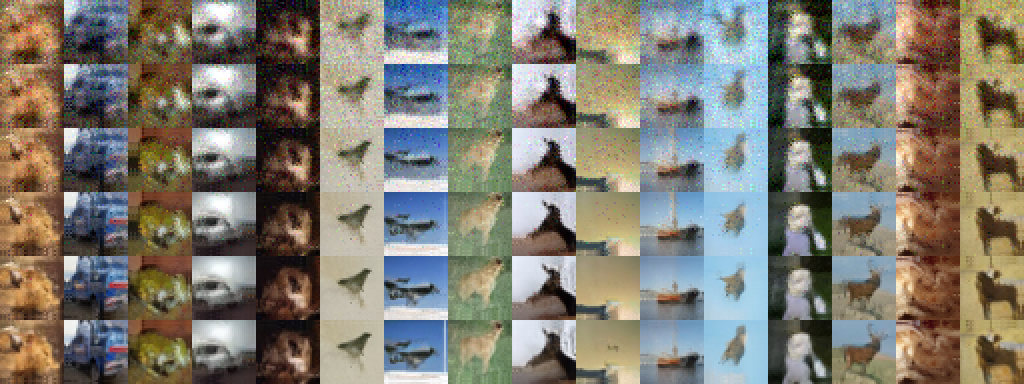

In [4]:
rows = []

for lap in (0, 1, 3, 7, 15, 31):
    model = load_module(PATH / f'runs/{run}/checkpoint_{lap}.pkl')

    x = sample_any(model, (16, 32 * 32 * 3), key=jax.random.key(0), sampler='ddim', steps=64)
    x = x.reshape(16, 32, 32, -1)

    rows.append(x)

grid = jnp.stack(rows)

to_pil(grid, zoom=2, file=f'cifar_prior_{run}.png')

## Inpainting

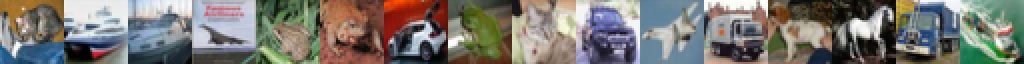

In [5]:
dataset = load_dataset('cifar10', cache_dir=PATH / 'hf')

x_gt = dataset['test'][:16]['img']
x_gt = jnp.stack(list(map(from_pil, x_gt)))

to_pil(x_gt, zoom=2)

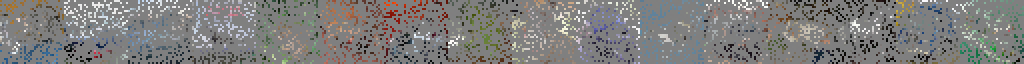

In [6]:
dataset = load_from_disk(PATH / 'hf/cifar-mask')
dataset.set_format('numpy')

testset_yA = dataset['test']
y, A = testset_yA[:16]['y'], testset_yA[:16]['A']

to_pil(y, zoom=2)

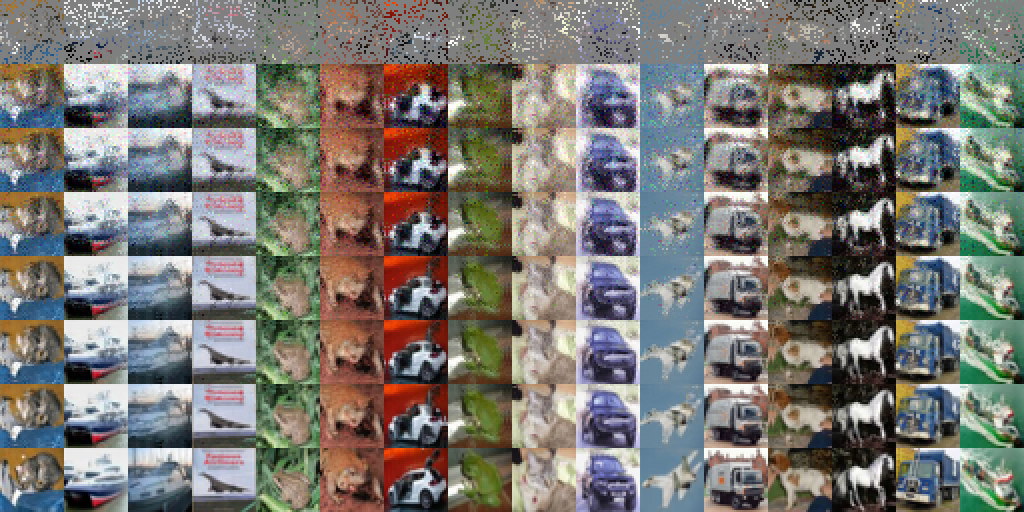

In [7]:
rows = []

for lap in (0, 1, 3, 7, 15, 31):
    model = load_module(PATH / f'runs/{run}/checkpoint_{lap}.pkl')

    x = sample(model, y, A, key=jax.random.key(0), steps=256, maxiter=1)
    x = x.reshape(16, 32, 32, -1)

    rows.append(x)

grid = jnp.stack((y, *rows, x_gt))

to_pil(grid, zoom=2, file=f'cifar_inpaint_{run}.png')